<font size="100" color='orangered'>Revealing Subreddits</font>

<img src="Reddit_logo_full_1.png">

# <font color='orangered'>Executive Summary

Reddit is a website that proclaims itself as the "front page of the internet." Reddit is broken up into millions of subreddits wherein each covers a different topic. For example, `/r/datascience/` is a subreddit for people to discuss data science. The notebook presents a study to determine the major themes or subreddits from reddit.com based on the title of threads. An aggregated list of thread titles and authors from a text file was used in the study. The file was preprocessed and cleaned by removing characters that are not word characters (e.g., punctuations and emojis) and foreign characters (e.g., 南部). TfidfVectorizer was used to make a vector representation of the titles. The TfidfVectorizer determines the importance of a set of words to a document by determining the frequency of occurence of words and penalizes the most frequenctly occuring words in the corpus. TruncatedSVD was used to get a reduced rank approximation of the titles for feature reduction to eliminate noise, synonymy, and polysemy. Kmeans clustering was used to determine the clusters formed based on the titles before and after using TruncatedSVD. Nine (9) clusters were formed from the vector from TF-IDF and six (6) clusters were formed after TruncatedSVD was used. Each cluster formed represent a community of similar titles or themes that may correspond to a possible subreddit. The titles assigned to each cluster are representative of the features or words that define the cluster. The clusters are able to capture the titles being discussed under the common theme in each cluster. Future directions of this algorithm can be extended as the engine of a forum moderator system. It can also be used for digital marketing targeting wherein similar words can be obtained based on the community being targeted.

In [322]:
# Importing the packages
import numpy as np
import pandas as pd

import re
import math
import pickle
import string
import collections
import matplotlib.pyplot as plt

from IPython.display import clear_output
from IPython.display import HTML

# Importing the packages from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.metrics import calinski_harabaz_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans

# Importing the packages from scipy
from scipy.spatial.distance import euclidean, cityblock

# <font color='orangered'>Table of contents

1. Introduction
2. Data Description
3. Data Preprocessing
    <br>2.1 Create a DataFrame
    <br>2.2 Data Cleaning
4. Exploratory Data Analysis
    <br>3.1 EDA on Titles
    <br>3.2 EDA on Author
5. Vector Representation Using TF-IDF
6. Models
    <br>6.1 KMeans Clustering Analysis of Bag-of-Words Using TF-IDF without TSVD
        6.1.1 Internal Validation
        6.1.2 KMeans Clustering
        6.1.3 Cluster Analysis
    <br>6.2 KMeans Clustering Analysis of Bag-of-Words Using TF-IDF with TSVD with 1000 Components
        6.2.1 Get Latent Semantic Analysis (LSA) at 1000 components using TSVD
        6.2.2 Internal Validation
        6.2.3 KMeans Clustering 
        6.2.4 Cluster Analysis
7. Results
8. References and Acknowledgments

# <font color='orangered'>1. Introduction

Reddit is a website that proclaims itself as the "front page of the internet." Reddit is broken up into millions of subreddits wherein each covers a different topic. For example, /r/datascience/ is a subreddit for people to discuss data science. There are numerous reasons why determining major themes and subreddits can be helpful for a forum community like reddit and external parties. For reddit, traffic is generated by users discussing topics under certain subreddits. Reddit can use clustering to identify emerging topics of discussion to create a new subreddit or to combine together threads into a subreddit. For external parties, this can be used to detect trends in a certain community or trends in the communities being formed. It can also be used by external parties for information dissemination by this new form of word of mouth.

The notebook presents a study to determine the major themes or subreddits from reddit.com based on the title of threads. This notebook will use data cleaning, information retrieval, and clustering in its analysis.

Source:<br>
https://www.digitaltrends.com/web/what-is-reddit/<br>
https://hypebeast.com/2019/7/reddit-ceo-steve-huffman-favorite-subreddits

# <font color='orangered'>2. Data Description

The data given, `reddit-dmw-sample.txt`, is an aggregated list of thread titles and authors in a text file. The dataset has 6000 rows. There was no actual subreddit mentioned in the data provided which leaves us with no ground truth for external validation readily available. 

In [810]:
f = open("reddit-dmw-sample.txt", "r")
i = 0
for x in f:
    if i > 10:
        break
    print(x)
    i += 1

	author	title

0	PrimotechInc	7 Interesting Hidden Features of apple ios9

1	xvagabondx	Need an advice on gaming laptop

2	nkindustries	Semi automatic ROPP Capping machine / ROPP Cap Sealing Machine

3	Philo1927	Microsoft Plumbs Ocean’s Depths to Test Underwater Data Center

4	tuyetnt171	OPPO F1 chính hãng - Fptshop.com.vn

5	onemantwohands	Stewed Ramps w/ Fixings in Helvatia, WV

6	[deleted]	(California) Is it a crime when a Religious figure/ Lecturer has relations with one of his followers

7	grant_brony	Being accused of public indecency, among other things. This is a misunderstanding because I had health issues. [Kansas, USA]

8	missfishersmurder	[US-CA/NV] My parents have been separated for almost 20 years, my mom found out my dad divorced her without her knowledge a few years ago when I was about 14--can she claim backdated child support?

9	weeds96	Skyrim Ps4?



# <font color='orangered'>3. Data Preprocessing

## <font color='orangered'>3.1 Create a DataFrame

It can be seen in the text file that it uses a tab delimiter as a separator. We will be saving the file into a dataframe with columns named `author` and `title`.

In [627]:
# Save the file into a DataFrame
df = pd.read_csv("reddit-dmw-sample.txt", sep='\t')
df.head(30)

,Unnamed: 0,author,title
0,0,PrimotechInc,7 Interesting Hidden Features of apple ios9
1,1,xvagabondx,Need an advice on gaming laptop
2,2,nkindustries,Semi automatic ROPP Capping machine / ROPP Cap...
3,3,Philo1927,Microsoft Plumbs Ocean’s Depths to Test Underw...
4,4,tuyetnt171,OPPO F1 chính hãng - Fptshop.com.vn
5,5,onemantwohands,"Stewed Ramps w/ Fixings in Helvatia, WV"
6,6,[deleted],(California) Is it a crime when a Religious fi...
7,7,grant_brony,"Being accused of public indecency, among other..."
8,8,missfishersmurder,[US-CA/NV] My parents have been separated for ...
9,9,weeds96,Skyrim Ps4?


## <font color='orangered'>3.2 Data Cleaning

We have to clean the data to prepare it for our clustering analysis. A clean set of titles would partially eliminate the noise in the data to help in the clustering analysis and match similar titles. We create a new column in the dataframe for a cleaned version of the titles. The goal of cleaning the data to remove characters that are not word characters (e.g., punctuations and emojis) and foreign characters (e.g., 南部).

In [628]:
# Removing Chinese Characters
df['clean'] = list(re.sub(r'[^\x00-\x7F]+', '', i.lower().strip())
                   for i in df['title'])
# Removing non-word characters and non-whitespace characters
df['clean'] = list(re.sub(r'[^\w\s]', '', i.lower()) for i in df['clean'])
# Dropping columns that are empty
df.drop(df[df['clean'] == ''].index, inplace=True)
#
df.head(30)

,Unnamed: 0,author,title,clean
0,0,PrimotechInc,7 Interesting Hidden Features of apple ios9,7 interesting hidden features of apple ios9
1,1,xvagabondx,Need an advice on gaming laptop,need an advice on gaming laptop
2,2,nkindustries,Semi automatic ROPP Capping machine / ROPP Cap...,semi automatic ropp capping machine ropp cap ...
3,3,Philo1927,Microsoft Plumbs Ocean’s Depths to Test Underw...,microsoft plumbs oceans depths to test underwa...
4,4,tuyetnt171,OPPO F1 chính hãng - Fptshop.com.vn,oppo f1 chnh hng fptshopcomvn
5,5,onemantwohands,"Stewed Ramps w/ Fixings in Helvatia, WV",stewed ramps w fixings in helvatia wv
6,6,[deleted],(California) Is it a crime when a Religious fi...,california is it a crime when a religious figu...
7,7,grant_brony,"Being accused of public indecency, among other...",being accused of public indecency among other ...
8,8,missfishersmurder,[US-CA/NV] My parents have been separated for ...,uscanv my parents have been separated for almo...
9,9,weeds96,Skyrim Ps4?,skyrim ps4


# <font color='orangered'>4. Exploratory Data Analysis

## <font color='orangered'>4.1 EDA on Titles

Before doing the clustering, we want to visualize the titles using a wordcloud. The wordcloud would display the frequency of occurence of the words, with the most frequent having the largest font size. Before doing this, we further clean the data by removing the stopwords. The stopwords we used were predefined from the english stopwords in the nltk corpus.

Clean the data using regex substitution to remove the special characters and remove stopwords from nltk. 

In [560]:
from nltk.corpus import stopwords
# You will have to download the set of stop words the first time
import nltk
nltk.download('stopwords')
stopwords = stopwords.words('english')

all_words = (" ".join(df['clean'])).split()
filtered_words = [w for w in all_words if not w in stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vanarloeyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [561]:
import matplotlib
matplotlib.rcParams['font.size'] = 16

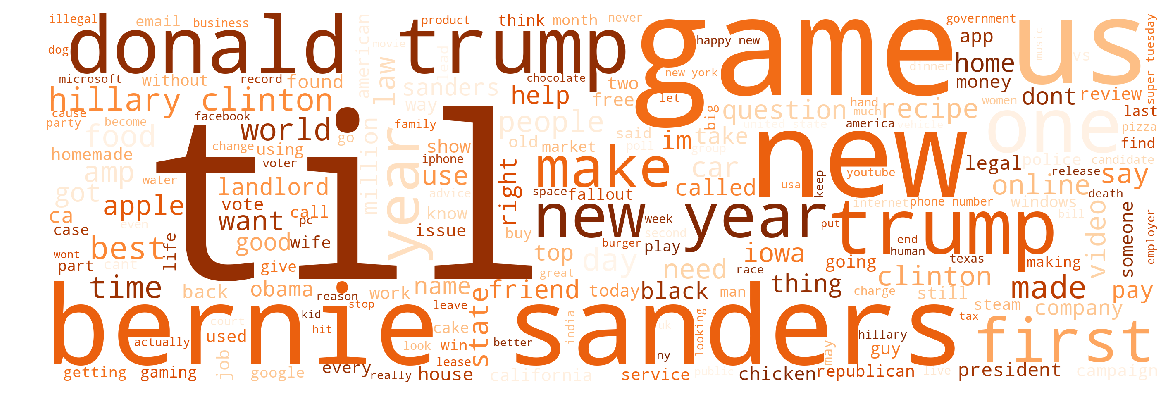

Text(0.5, 1.0, 'Most Frequently Occuring Words in Titles')

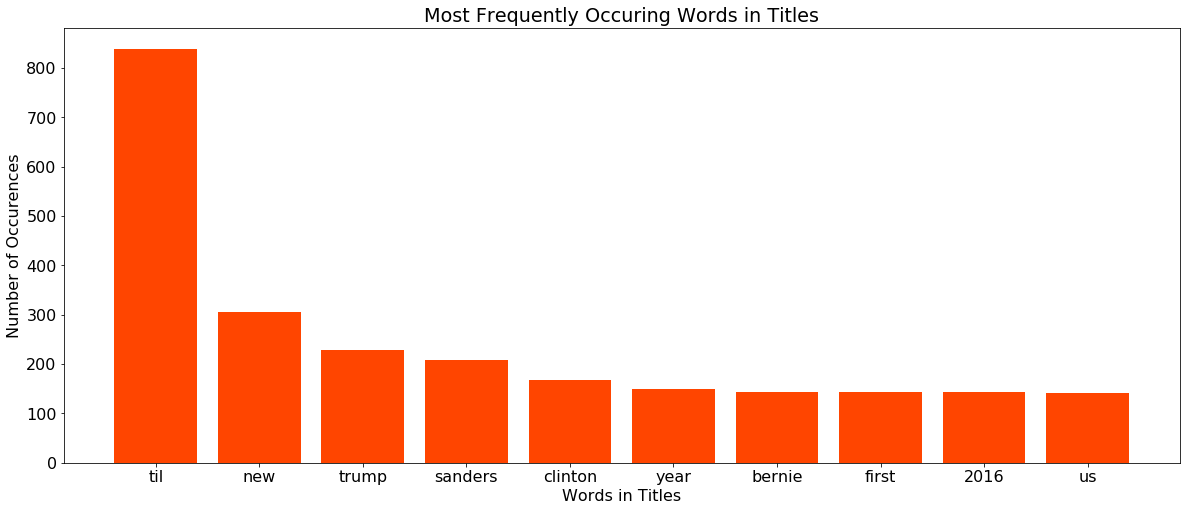

In [562]:
import wordcloud as wc

c0_wc = wc.WordCloud(background_color='white', colormap='Oranges',
                     width=2700, 
                     height=900).generate(" ".join(filtered_words))

plt.figure(figsize=(20, 8))
plt.imshow(c0_wc)
plt.axis('off')
plt.show()

word_count = collections.Counter(filtered_words)
top_word = word_count.most_common()

titles = list(k for k, v in top_word)
freq = list(v for k, v in top_word)
plt.figure(figsize=(20, 8))
plt.bar(titles[:10], freq[:10], color='orangered', orientation='vertical')
plt.xlabel('Words in Titles')
plt.ylabel('Number of Occurences')
plt.title('Most Frequently Occuring Words in Titles')

We can see from the wordcloud and bar chart that the prevailing words are 'til', 'sanders', 'clinton', 'bernie', 'donald', and 'hillary' among others. It is important to note however that these words do not define the clusters that must be formed in our analysis, it only serves as a description on what are the most frequently occuring words in the text. It can only help our intuition to sense check the output of our clustering.


## <font color='orangered'>4.2 EDA on Authors

Next we can look at the different authors of the different topics. Are these coming from unique authors or are there repeating authors? We visualized the most occuring authors using a wordcloud and a bar chart.

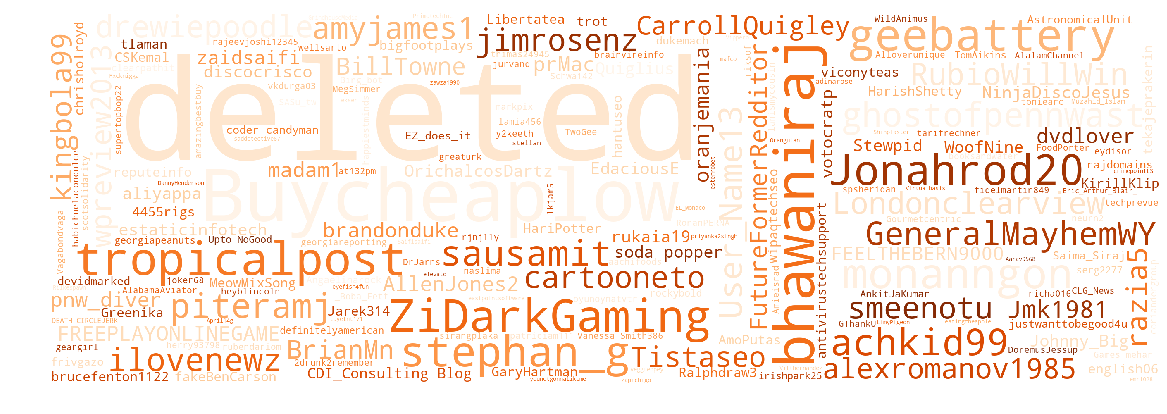

Text(0.5, 1.0, 'Most Frequently Occuring Words in Authors')

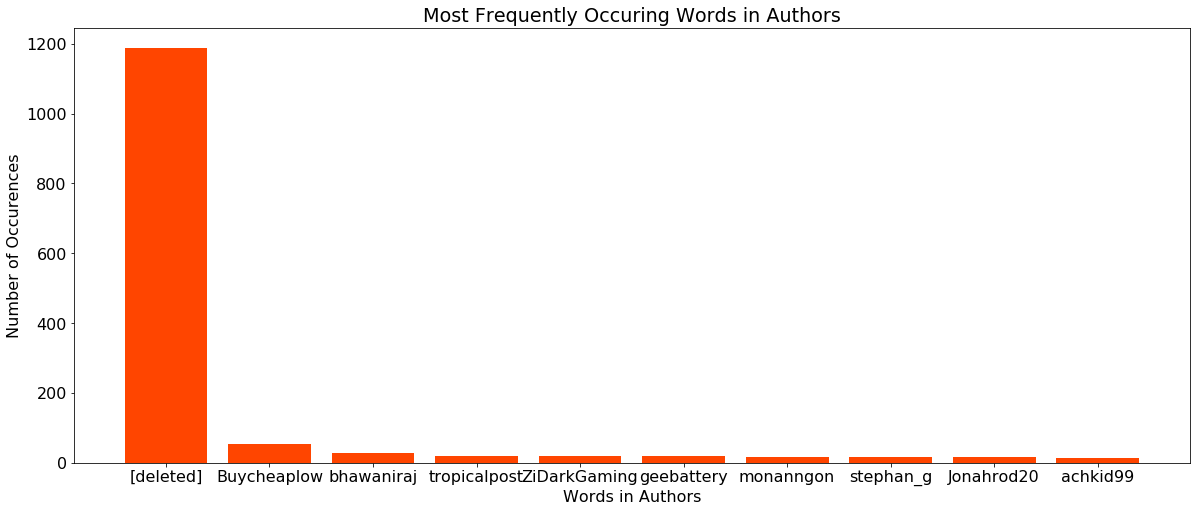

In [563]:
import wordcloud as wc

c0_wc = wc.WordCloud(background_color='white', colormap='Oranges',
                     width=2700, 
                     height=900).generate(" ".join(df['author']))

plt.figure(figsize=(20, 8))
plt.imshow(c0_wc)
plt.axis('off')
plt.show()

word_count = collections.Counter(df['author'])
top_word = word_count.most_common()

titles = list(k for k, v in top_word)
freq = list(v for k, v in top_word)
plt.figure(figsize=(20, 8))
plt.bar(titles[:10], freq[:10], color='orangered', orientation='vertical')
plt.xlabel('Words in Authors')
plt.ylabel('Number of Occurences')
plt.title('Most Frequently Occuring Words in Authors')


Interesting, a lot of posts have `[deleted]` authors. It would be interesting to see what are the titles being discussed by them. Let's try to explore in which clusters are the authors posting later.

# <font color='orangered'>5. Vector Representation

In clustering the titles, we will be computing the distances between texts. But there is no direct way to compute distances between texts. In order to cluster the titles, we must find a representation for the words in the text. One of the ways to do this is to represent the text as vectors. Bag-of-words representation expresses the text as multidimensional quantitative data.

The vector contains components that correspond to a unique word with with a value that essentially shows the frequency count of each word in the text. It is important to note that this method removes the order of the words and their context. However, for this application this representation would suffice.

We will be using TFIDF vectorizer to make the bag-of-words representation in this application. The TFIDF vectorizer uses the concept of term frequency and inverse document frequency. It creates a matrix of word frequency and reweight the words using the inverse document frequency. The TFIDF weighs down words that appear a lot of times and have little importance. The TFIDF is a good tool to filter out stop-words and retain important information in creating a bag-of-words representation.

We will indicate to filter the clean titles using english stopwords using sci-kit learn's implementation of TfidfVectorizer.

In [629]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
bow_title = tfidf_vectorizer.fit_transform(df['clean'])

In [630]:
bow_title.shape

(5998, 13156)

Checking the shape of the bow shows how many features does the document have. This will show how large the data we are dealing with. Since the data is not too large. We can attempt clustering first before doing any further dimensional reduction. 

# <font color='orangered'>6. Models

Clustering is a way to group mutually similar objects. It finds the intersection of the results of information retrieval operations like the bag-of-words representation using TFIDF. 

Clustering is a type of unsupervised machine learning such that there is no ground truth as to which results can be compared to. Clustering partitions data points into clusters wherein the objects in the clusters are similar. When clustering is performed there is no guarantee that the resulting clusters will have a specific set of words or characteristics in them. In this application, we can only say that the documents will be clustered using the title, but there's no guarantee how the feature values would cluster. This presents the challenge of choosing the optimal clustering method and optimal clustering parameter.

In this report, we will be using a representative-based clustering method with k-means clustering

## <font color='orangered'>K-means Clustering

K-means is a representative-based clustering method. This family of clustering methods assigns representative point, which may or may not be a data point, to each cluster. The data points are assigned to the nearest representative point and then a new representative point is chosen in the cluster. This method repeats until it converges.

The simplest and most popular representative-based clustering method is  𝑘-means clustering. The representative is chosen to be the mean of the points in the cluster.

The three noteable features of k-means are:
- Euclidean distance is used as a metric and variance is used as a measure of cluster scatter. The distance function in this method is the L2-norm or the squared sum error (SSE), which is just the square of the L2 norm.
- The input paramater in implementation is the number of clusters k, which can be hard to identify. An inappropriate k would lead to poor clustering results.
- Convergence to a local minimum may produce inappropriate results

As metioned earlier, the number of clusters k is the input parameter for k-means. We can be guided to identify the appropriate k through validation methods. There are two types of validation method, internal and external validation criteria. In this application we will only be using internal validation to evaluate the results, because we cannot do an external validation since we don't have any ground truth. 


# <font color='orangered'>6.1 KMeans Clustering Analysis of Bag-of-Words Using TF-IDF without TSVD



## <font color='orangered'>6.1.1 Internal Validation    

In order to identify the optimal k parameter of the clusters, we use the following internal cluster validation metrics:

- Sum of Squares Distances to centroids (SSE): This metric indicates the distances of the individual data points from their respective cluster centroids. The smaller the distances suggest that the data points are more clumped.
- Silhouette coefficient (SCS): Values range from -1 to 1 where 1 means there is good separation among clusters and -1 indicates some level of intersection between clusters.
- Intracluster to intercluster distance ratio (IIDR): This is the ratio between the average distance of two data points within the same cluster versus the average distance between two data points belonging to another cluster.
- Calinski-Harabasz index (CHI) : Also known as the Variance Ratio Criterion, it is the ratio of the between-clusters dispersion mean and the within-cluster dispersion. The higher the value of this measure, the more defined the clusters are.

In general, small values for SSE and IIDRS and high values for SCS and CHI are ideal for clustering quality.

We use the sklearn library for  k-means clustering, silhouette_score, and calinski_harabaz_score. We will use the intra_to_inter function below of the Intracluster to intercluster distance ratio.

In [304]:
# This function is used to Intracluster to intercluster distance ratio (IIDR)
def intra_to_inter(X, y, dist, r):
    """Compute intracluster to intercluster distance ratio
    
    Parameters
    ----------
    X : array
        Data matrix with each row corresponding to a point
    y : array
        Class label of each point
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    r : integer
        Number of pairs to sample
        
    Returns
    -------
    ratio : float
        Intracluster to intercluster distance ratio
    """
    dist_P = []
    dist_Q = []
    for i, j in np.random.randint(low=0, high=len(y), size=[r,2]):
        # just skip the pair even if we end up having pairs less than r
        if i == j:
            continue
        # intracluster
        elif y[i] == y[j]:
            dist_P.append(dist(X[i], X[j]))
        # intercluster
        else:
            dist_Q.append(dist(X[i], X[j]))
           
    intra = np.sum(dist_P) / len(dist_P)
    inter = np.sum(dist_Q) / len(dist_Q)
    ratio = intra / inter
    return ratio

In [637]:
X_art = bow_title.toarray()
inertias_full = []
iidrs_full = []
scs_full = []
chlist_full = []
for i in range(2, 12):
    kmeans = KMeans(n_clusters=i, random_state=1337)
    y = kmeans.fit_predict(X_art)
    inertias_full.append(kmeans.inertia_)
    iidrs_full.append(intra_to_inter(X_art, y, euclidean, 50))
    scs_full.append(silhouette_score(X_art, y))
    chlist_full.append(calinski_harabaz_score(X_art, y))

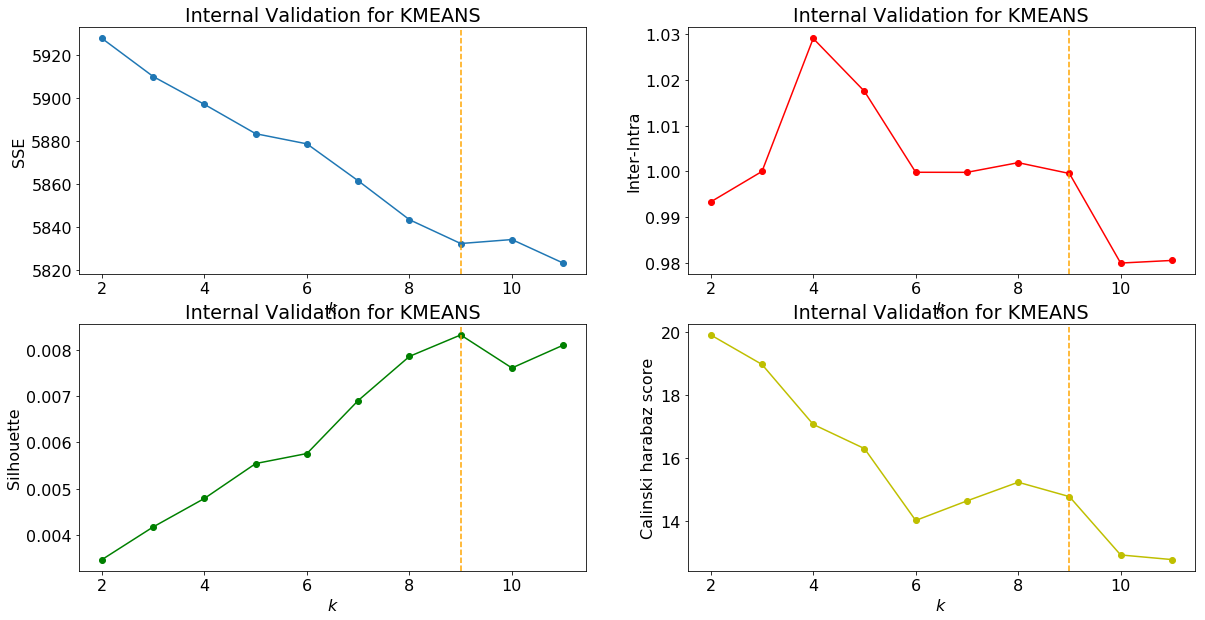

In [642]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

ax[0][0].plot(np.arange(2,12), inertias_full, '-o', label='SSE')
ax[0][0].set_xlabel('$k$')
ax[0][0].set_ylabel('SSE')
ax[0][0].set_title('Internal Validation for KMEANS')
ax[0][0].axvline(x=9, color='orange', linestyle='dashed')


ax[0][1].plot(np.arange(2,12), iidrs_full, '-ro', label='Inter-intra')
ax[0][1].set_xlabel('$k$')
ax[0][1].set_ylabel('Inter-Intra')
ax[0][1].set_title('Internal Validation for KMEANS')
ax[0][1].axvline(x=9, color='orange', linestyle='dashed')


ax[1][0].plot(np.arange(2,12), scs_full, '-go', label='Silhouette coefficient')
ax[1][0].set_xlabel('$k$')
ax[1][0].set_ylabel('Silhouette')
ax[1][0].set_title('Internal Validation for KMEANS')
ax[1][0].axvline(x=9, color='orange', linestyle='dashed')


ax[1][1].plot(np.arange(2,12), chlist_full, '-yo', label='Calinski harabaz score')
ax[1][1].set_xlabel('$k$')
ax[1][1].set_ylabel('Calinski harabaz score')
ax[1][1].set_title('Internal Validation for KMEANS')
ax[1][1].axvline(x=9, color='orange', linestyle='dashed')


Using the elbow method, we chose the number of clusters k as 9 since the SSE shows an elbow or sudden change in SSE at k = 9. It is high in the Silhouette coefficient (SCS) and high in Calinski-Harabasz index (CHI) which both favorable. However it is not low for Intracluster to intercluster distance ratio (IIDR) which means there are overlaps in the data.

## <font color='orangered'>6.1.2 KMeans Clustering 

In [808]:
k = 9

df['Cluster_pure'] = KMeans(n_clusters=k, random_state = 1337).fit(bow_title).labels_

cluster_list = {}
for i in range(k):
    cluster_list[i] = df[df['Cluster_pure']==i]

top_df = pd.DataFrame()
for i in range(k):
    x = pd.Series(top_words(cluster_list[i]['clean'], ngram = (1,1), n=10), 
                  name = 'Cluster_{} \n({}%)'.format(i+1,round((len(cluster_list[i])*100/len(df)),2)))
    top_df = top_df.append(x)

top_df.T

,Cluster_1 (68.51%),Cluster_2 (3.73%),Cluster_3 (1.98%),Cluster_4 (3.28%),Cluster_5 (1.35%),Cluster_6 (13.39%),Cluster_7 (2.53%),Cluster_8 (1.53%),Cluster_9 (3.68%)
0,"(new, 101)","(game, 110)","(2016, 120)","(sanders, 196)","(need, 77)","(til, 804)","(new, 139)","(car, 95)","(trump, 211)"
1,"(clinton, 96)","(number, 73)","(vines, 18)","(bernie, 138)","(help, 21)","(people, 43)","(year, 74)","(accident, 19)","(donald, 116)"
2,"(just, 87)","(support, 70)","(reaction, 18)","(clinton, 48)","(advice, 19)","(years, 42)","(happy, 53)","(hit, 13)","(rally, 21)"
3,"(hillary, 86)","(question, 42)","(compilation, 18)","(iowa, 28)","(legal, 6)","(world, 34)","(years, 44)","(selfdriving, 12)","(trumps, 21)"
4,"(food, 79)","(phone, 32)","(games, 17)","(hillary, 27)","(dont, 4)","(called, 33)","(day, 12)","(insurance, 12)","(til, 19)"
5,"(best, 75)","(technical, 23)","(january, 15)","(campaign, 19)","(pay, 4)","(year, 28)","(eve, 11)","(google, 8)","(clinton, 16)"
6,"(online, 65)","(hotmail, 20)","(february, 11)","(new, 15)","(probably, 3)","(new, 28)","(owned, 10)","(model, 7)","(iowa, 15)"
7,"(review, 60)","(tech, 18)","(new, 6)","(trump, 13)","(usa, 3)","(states, 23)","(birthday, 10)","(tesla, 6)","(supporters, 14)"
8,"(amp, 59)","(18777889452, 15)","(2015, 5)","(democratic, 12)","(life, 3)","(million, 23)","(internet, 7)","(ca, 6)","(black, 11)"
9,"(iowa, 59)","(free, 14)","(best, 5)","(poll, 11)","(fix, 2)","(used, 22)","(people, 7)","(time, 5)","(rubio, 11)"


## <font color='orangered'>6.1.3 Cluster Analysis

In [640]:
def top_words(text, ngram = (1,1), n=None):
    """Returns most frequently occuring words
    
    Parameters
    ----------
    text : list, series, dataframe
        text data
    ngram : tuple
        ngram range 
    n : integer
        number of top words to display
        
    Returns
    -------
    word_count: list
        list of top words sorted
    """
    vec = CountVectorizer(stop_words='english', lowercase=True, ngram_range = ngram, min_df = 0.0005).fit(text)
    bows = vec.transform(text)
    total_words = bows.sum(axis=0) 
    word_count = [(word, total_words[0, idx]) for word, idx in  vec.vocabulary_.items()]
    word_count =sorted(word_count, key = lambda x: x[1], reverse=True)
    return word_count[:n]

Cluster_ 1


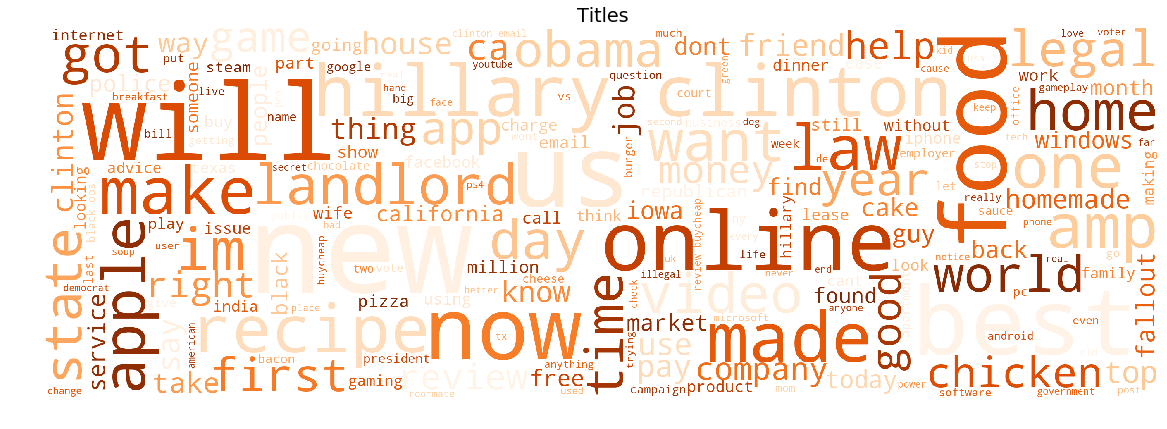

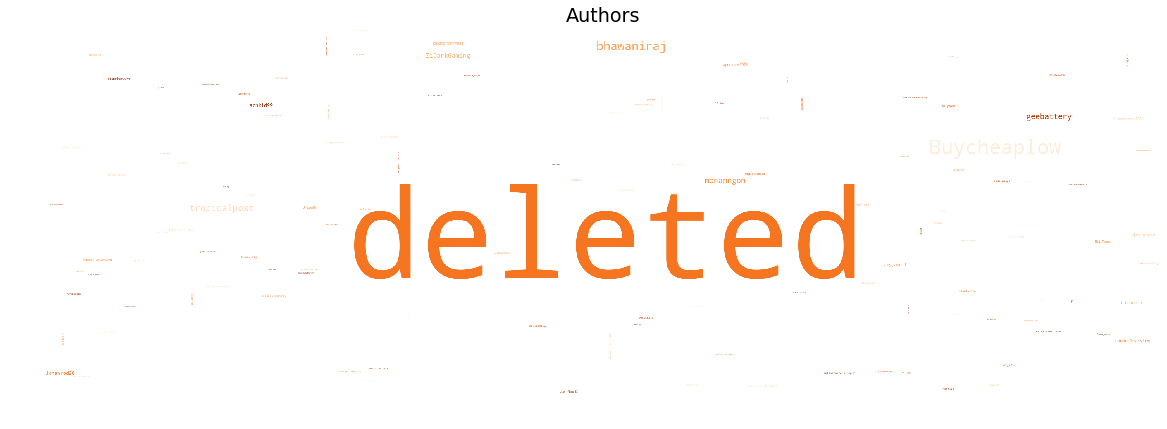

Cluster_ 2


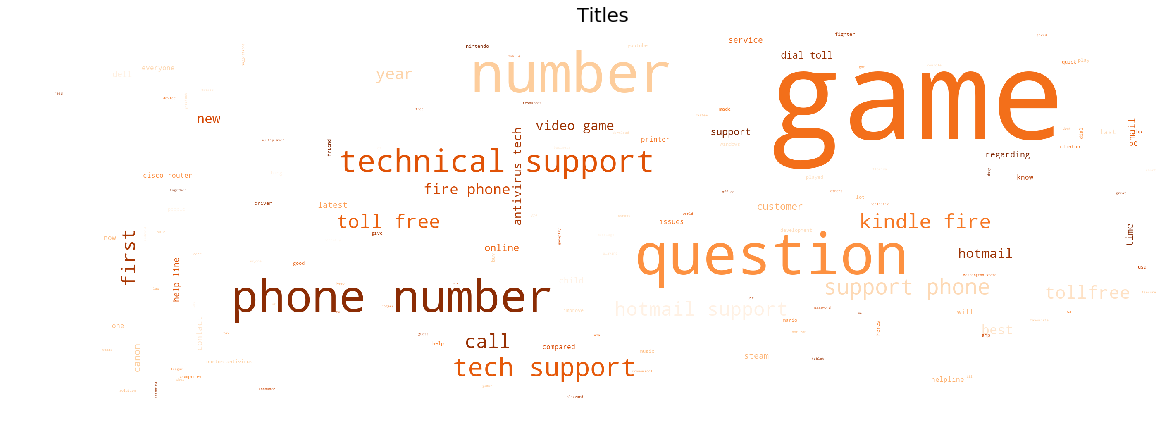

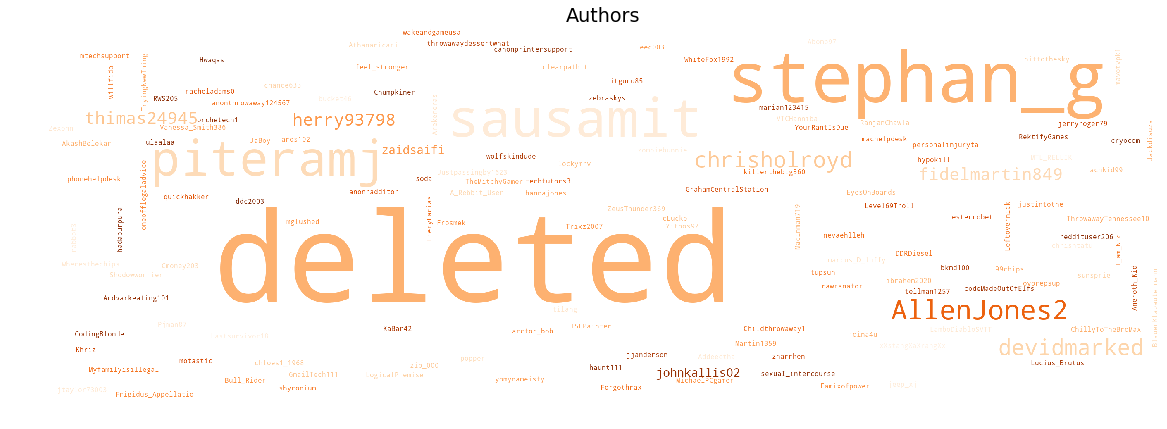

Cluster_ 3


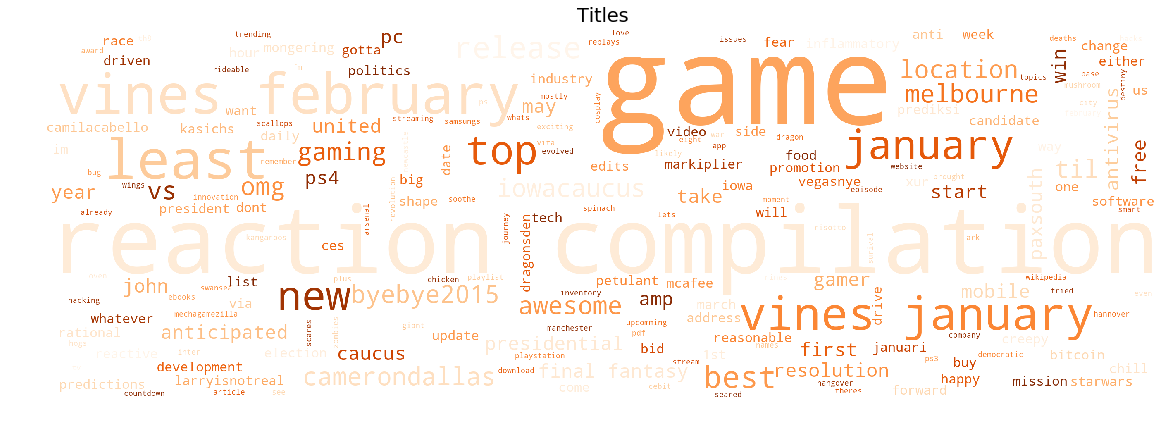

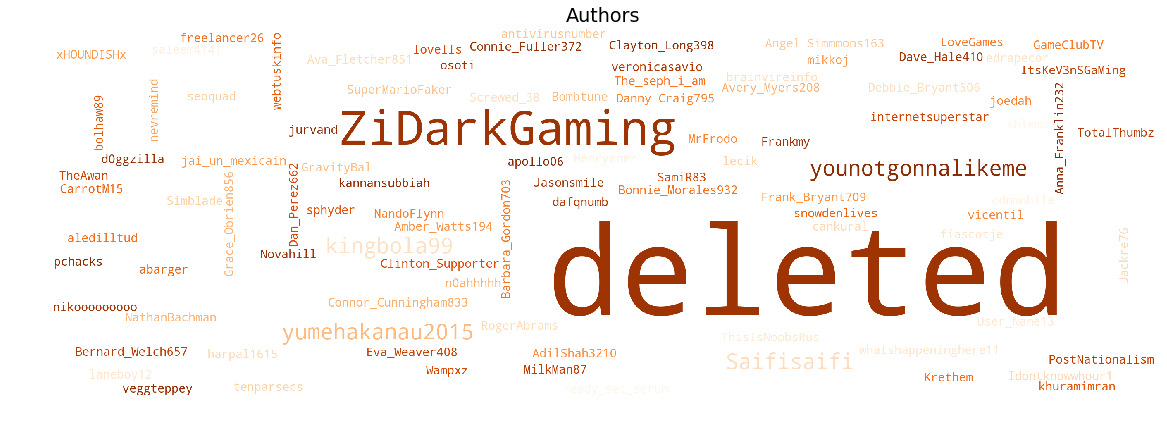

Cluster_ 4


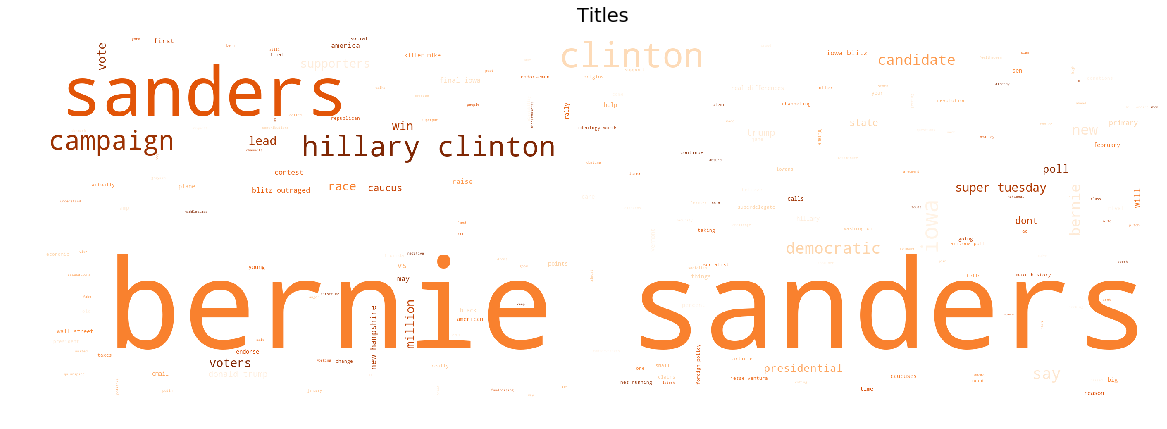

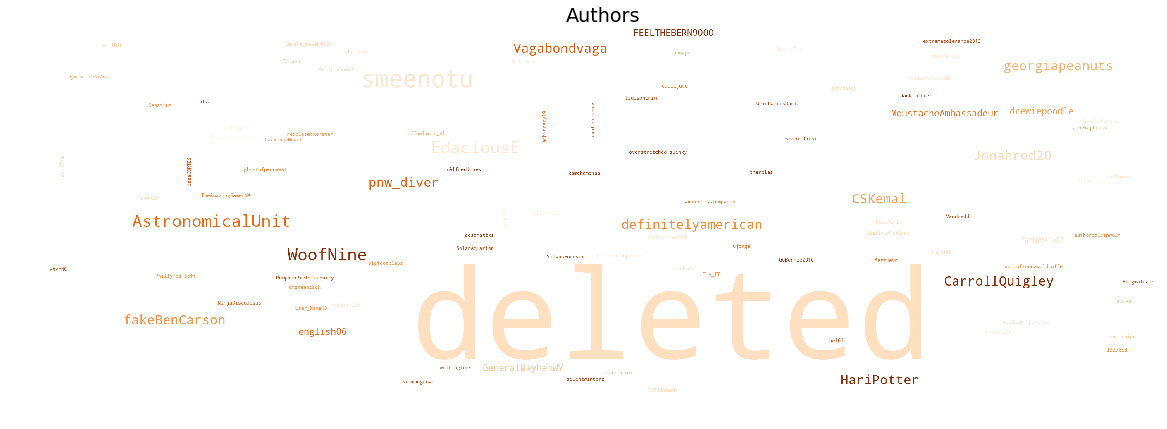

Cluster_ 5


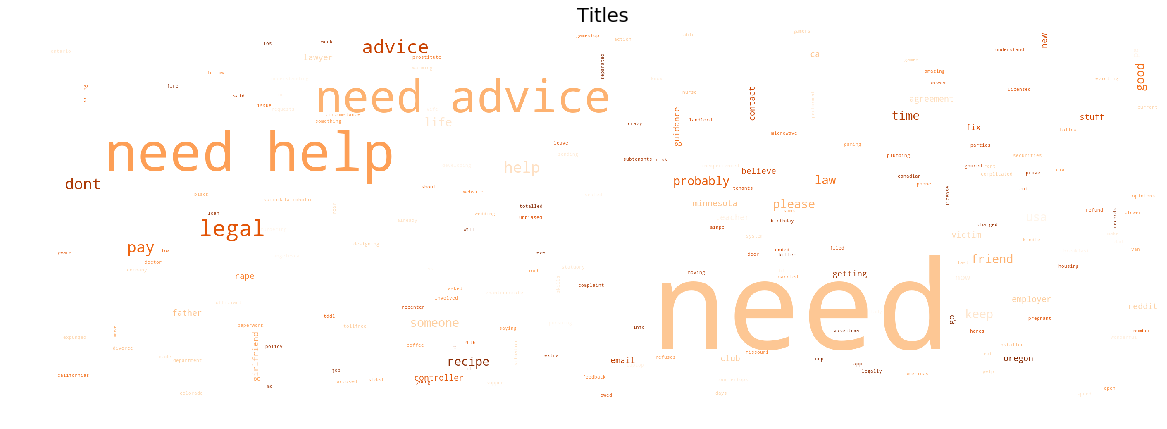

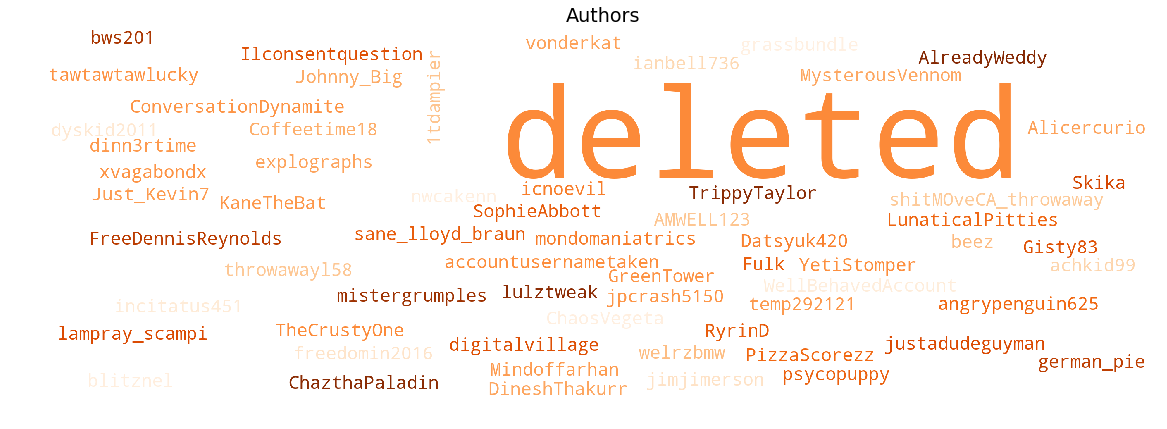

Cluster_ 6


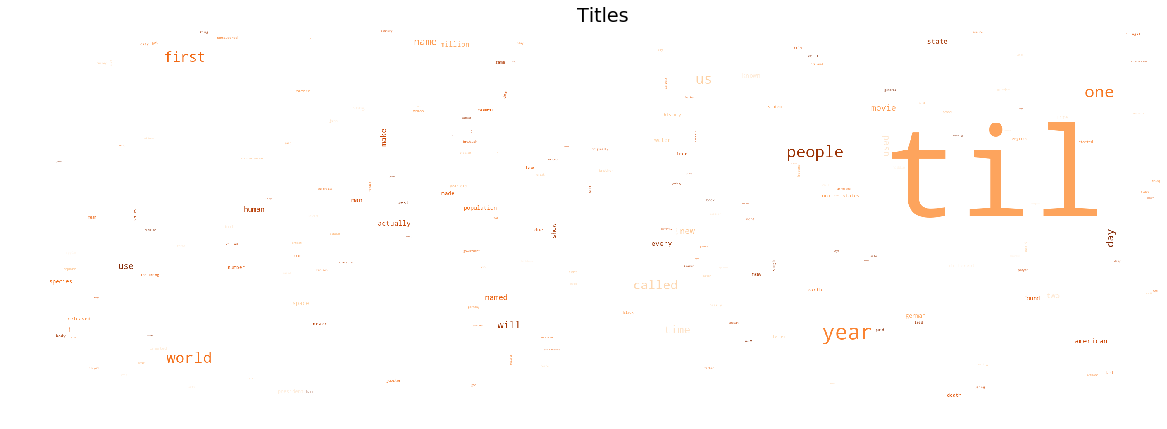

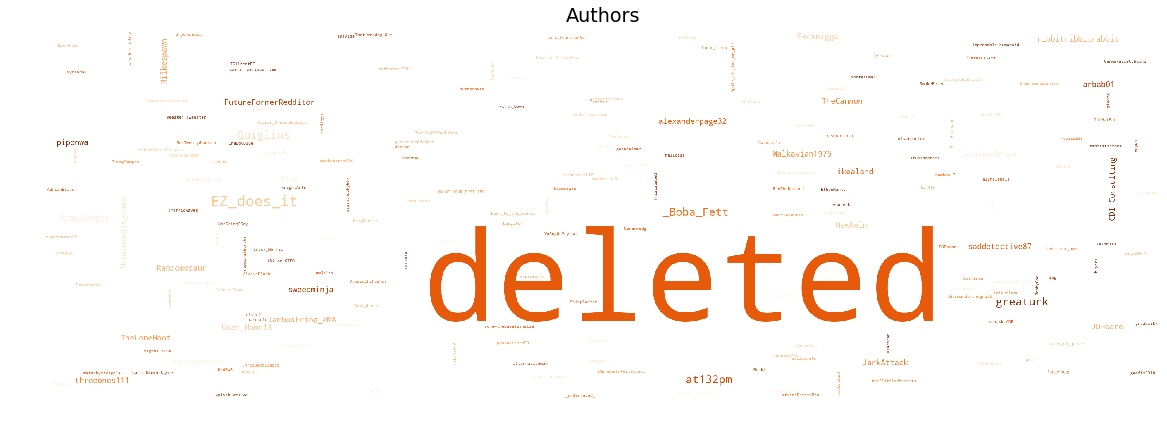

Cluster_ 7


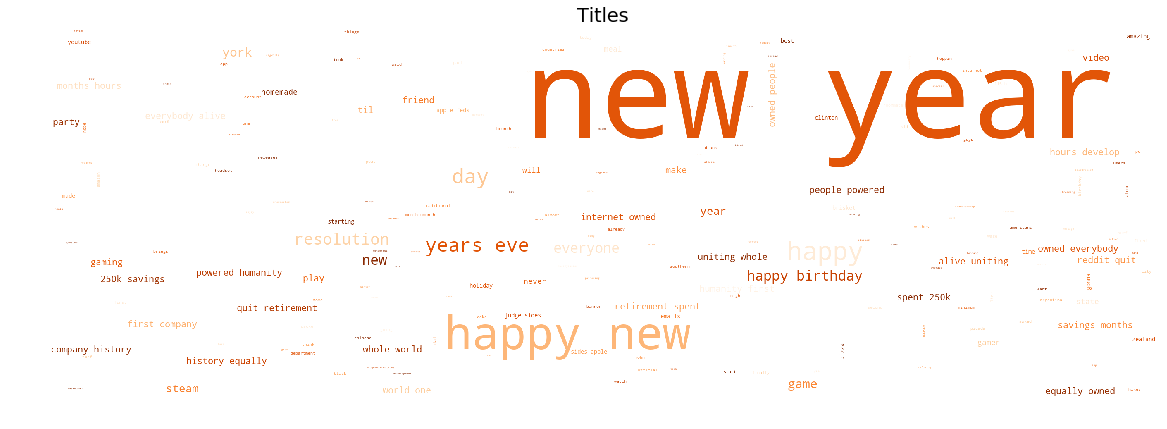

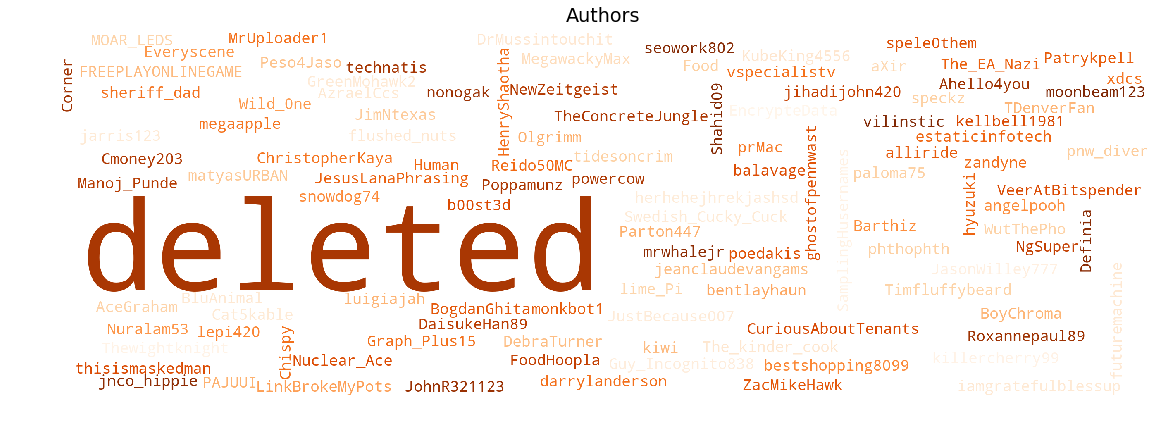

Cluster_ 8


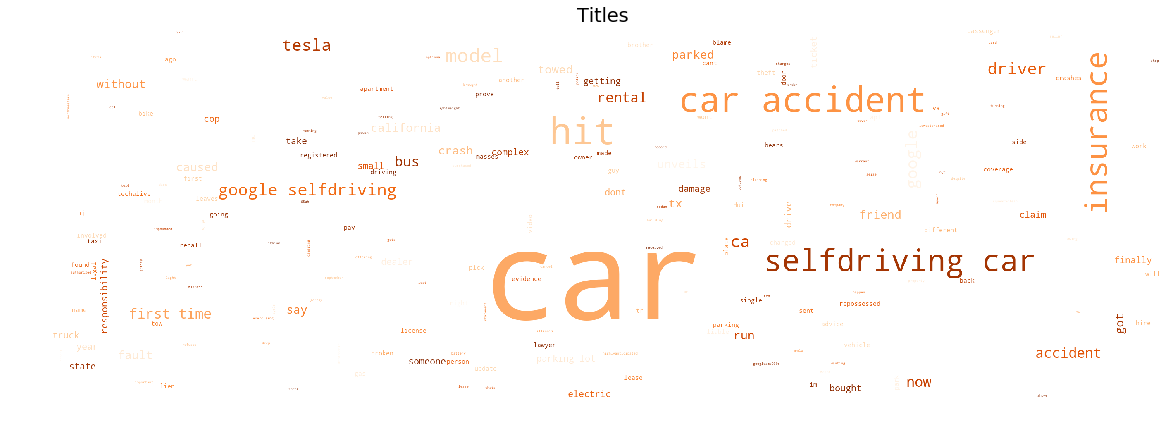

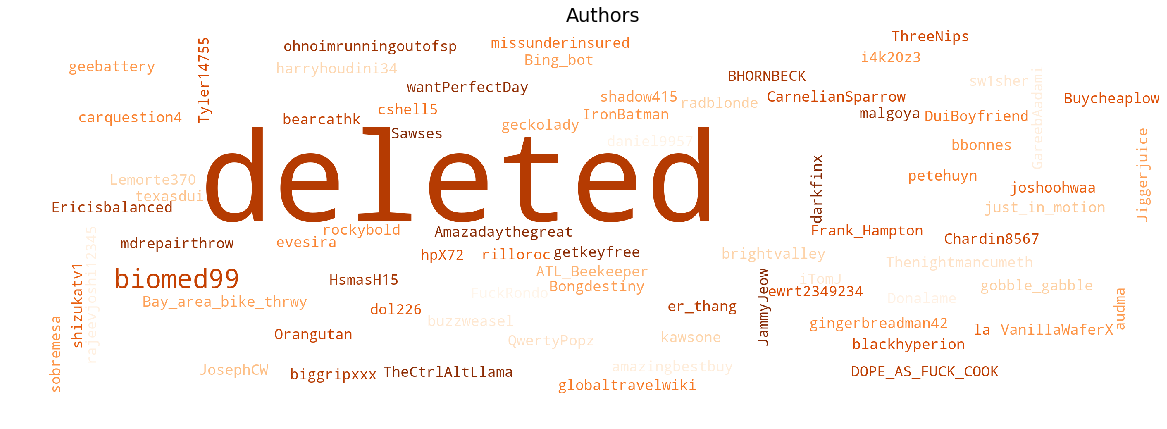

Cluster_ 9


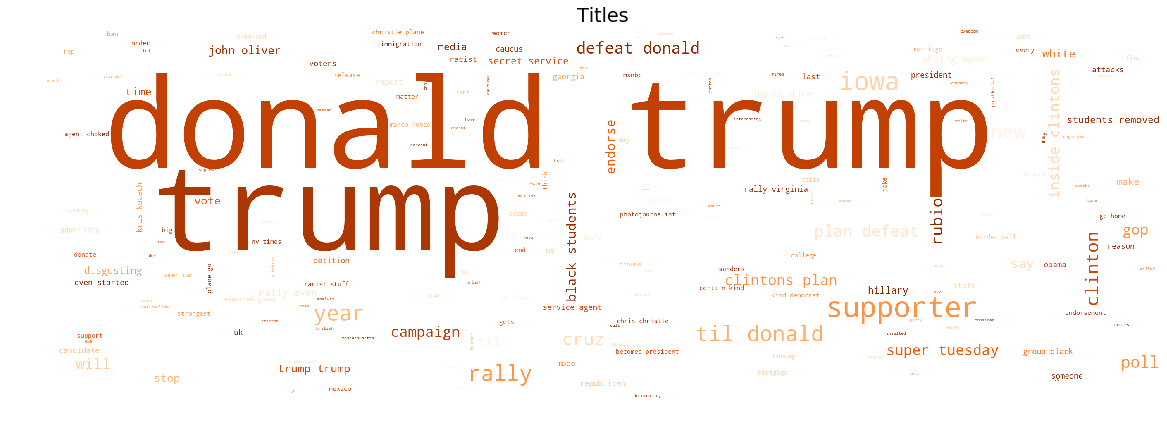

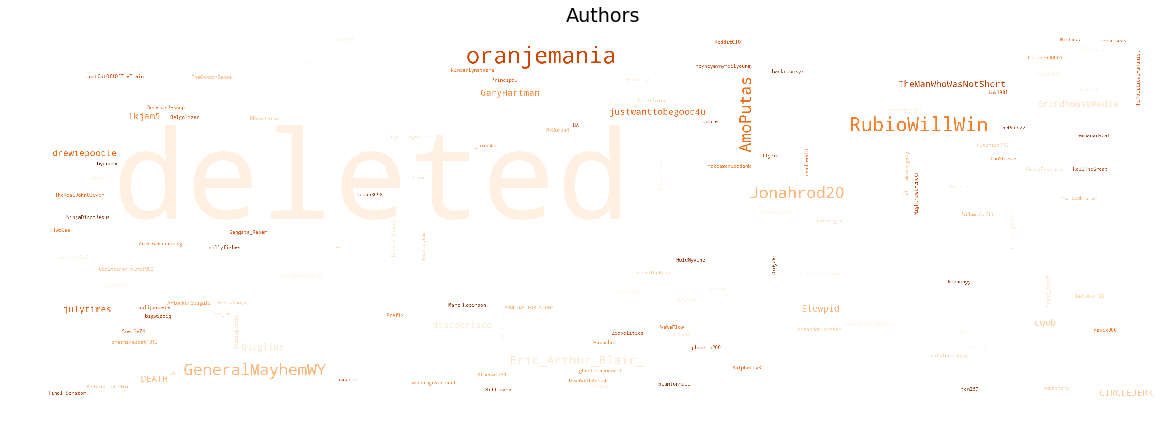

In [809]:
import wordcloud as wc
for i in range(0,9):
    print("Cluster_",i+1)
    c0_wc = wc.WordCloud(background_color='white', colormap='Oranges',width=2700,
                         height=900, relative_scaling=0.9,max_font_size=300,
                         min_font_size=5).generate(
        cluster_list[i]['clean'].str.cat(sep=' '))

    plt.figure(figsize=(20,8))
    plt.title("Titles")
    plt.imshow(c0_wc)
    plt.axis('off')
    plt.show()
    
    c0_wc = wc.WordCloud(background_color='white', colormap='Oranges',width=2700,
                         height=900, relative_scaling=0.9,max_font_size=300,
                         min_font_size=5).generate(
        cluster_list[i]['author'].str.cat(sep=' '))

    plt.figure(figsize=(20,8))
    plt.title("Authors")
    plt.imshow(c0_wc)
    plt.axis('off')
    plt.show()


By using the kmeans clustering on the bag of words from tfidf with 9 clusters, we were able to reveal the nine (9) different themes as the following:
1. Hillary Clinton, new, food, etc
2. Tech and games
3. Vines and games
4. Bernie Sanders
5. Need help
6. TIL (today I learned)
7. New Year
8. Car 
9. Donald Trump

We failed to find any pattern where the '[deleted]' author was posting since it was present in all the clusters.

Normally, the quality of clustering is determined using several validation criteria. Since we do not have a ground truth to evaluate of quality of the clustering, we just rely on our intuition and understanding of language to validate whether the cluster solve the problem being solved. The clusters formed had clear themes except for cluster 1 that was a mix of different themes. Recalling that clustering is a method of unsupervised learning and we cannot control how the clusters would form. What we can do next to reduce the noise in the titles, such that the prominent themes would prevail more above the noise. Next, we would be using TruncatedSVD to do a Latent Semantic Analysis (LSA) for text classification.


# <font color='orangered'>6.2 KMeans Clustering Analysis of Bag-of-Words Using TF-IDF  and TSVD


We will do a Latent Semantic Analysis (LSA) using Truncated Singular Value Decomposition with TruncatedSVD. The TruncatedSVD method reduces the computational load and gives a smaller set of better features. 

The use of LSA if given by these reasons:
1. The resulting output of LSA is a low-rank approximation that is requires less computing resources. 
2. The approximation eliminates noise in the data. An example of noise in the data are anecdotal instances of terms. 
3. It mitigates the problem of synonymy where words merge with those with similar meanings.
4. It partially mitigates polysemy where words that point in the "right" direction are added to components of words with a similar meaning.

Before doing the LSA, we must first identify the number of components in the LSA. The number of components is determind by the intention of the study. 

The intention can be to simply reduce the number of features for decreasing required computational resource while still retaining as much of the original text as much as possible. You can do this by finding the number of components that gives you a high explained variance of 95%. 

In the next test, however, we intend to eliminate the noise in the data. We do not need to retain the whole text in our analysis, according to researchers Landauer and Dumais, 50-1000 components would be enough for this application (Landauer and Dumais, 2008). Using a low number of components would retain the information that would be beneficial for the clustering. We will be using 1000 components for this application.

Source:
Thomas K Landauer and Susan Dumais (2008), Scholarpedia, 3(11):4356. http://www.scholarpedia.org/article/Latent_semantic_analysis

## <font color='orangered'>6.2.1 Get Latent Semantic Analysis (LSA) with 1000 Components

In [792]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
bow_title_ngram = tfidf_vectorizer.fit_transform(df['clean'])


In [793]:
lsa_400 = TruncatedSVD(n_components = 1000, random_state=1337)
bow_title_lsa_400 = lsa_400.fit_transform(bow_title_ngram)


In [794]:
bow_title_lsa_400.shape

(5998, 1000)

## <font color='orangered'>6.2.2 Internal Validation


In [797]:
X_art = bow_title_lsa_400
inertias_400 = []
iidrs_400 = []
scs_400 = []
chlist_400 = []
for i in range(2, 12):
    kmeans = KMeans(n_clusters=i, random_state=1337)
    y = kmeans.fit_predict(X_art)
    inertias_400.append(kmeans.inertia_)
    iidrs_400.append(intra_to_inter(X_art, y, euclidean, 50))
    scs_400.append(silhouette_score(X_art, y))
    chlist_400.append(calinski_harabaz_score(X_art, y))

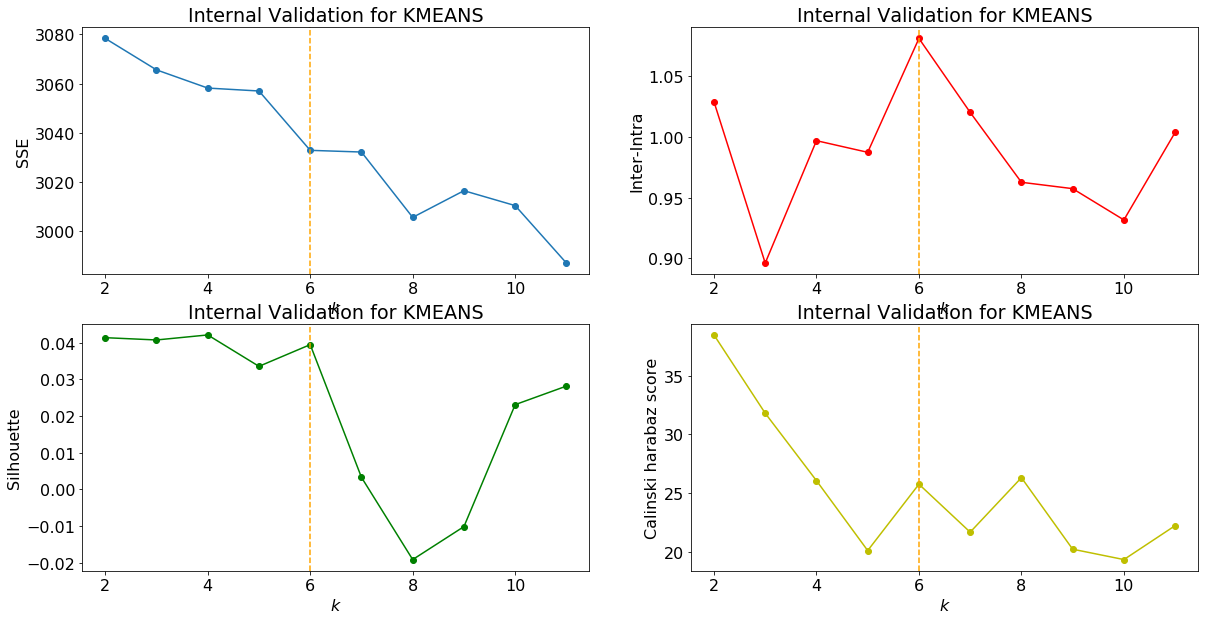

In [798]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

ax[0][0].plot(np.arange(2,12), inertias_400, '-o', label='SSE')
ax[0][0].set_xlabel('$k$')
ax[0][0].set_ylabel('SSE')
ax[0][0].set_title('Internal Validation for KMEANS')
ax[0][0].axvline(x=6, color='orange', linestyle='dashed')


ax[0][1].plot(np.arange(2,12), iidrs_400, '-ro', label='Inter-intra')
ax[0][1].set_xlabel('$k$')
ax[0][1].set_ylabel('Inter-Intra')
ax[0][1].set_title('Internal Validation for KMEANS')
ax[0][1].axvline(x=6, color='orange', linestyle='dashed')


ax[1][0].plot(np.arange(2,12), scs_400, '-go', label='Silhouette coefficient')
ax[1][0].set_xlabel('$k$')
ax[1][0].set_ylabel('Silhouette')
ax[1][0].set_title('Internal Validation for KMEANS')
ax[1][0].axvline(x=6, color='orange', linestyle='dashed')


ax[1][1].plot(np.arange(2,12), chlist_400, '-yo', label='Calinski harabaz score')
ax[1][1].set_xlabel('$k$')
ax[1][1].set_ylabel('Calinski harabaz score')
ax[1][1].set_title('Internal Validation for KMEANS')
ax[1][1].axvline(x=6, color='orange', linestyle='dashed')


Using the elbow method, we chose the number of clusters k as six (6) since the SSE shows an elbow or sudden change in SSE at six (6) clusters. It is high in the Silhouette coefficient (SCS) and high in Calinski-Harabasz index (CHI) which are both favorable. Although, it can be noted that it is low in Intracluster to intercluster distance ratio (IIDR). We choose number of clusters k at six (6) which satisfies three out of four of our internal validations.

## <font color='orangered'>6.2.3 KMeans Clustering 


In [802]:
k = 6

df['Cluster_400'] = KMeans(n_clusters=k, random_state = 1337).fit(bow_title_lsa_400).labels_

cluster_list = {}
for i in range(k):
    cluster_list[i] = df[df['Cluster_400']==i]

top_df = pd.DataFrame()
for i in range(k):
    x = pd.Series(top_words(cluster_list[i]['clean'], ngram = (1,1), n=10), 
                  name = 'Cluster_{} \n({}%)'.format(i+1,round((len(cluster_list[i])*100/len(df)),2)))
    top_df = top_df.append(x)

top_df.T

,Cluster_1 (0.48%),Cluster_2 (6.22%),Cluster_3 (3.22%),Cluster_4 (1.33%),Cluster_5 (85.1%),Cluster_6 (3.65%)
0,"(reddit, 19)","(new, 249)","(sanders, 192)","(help, 81)","(til, 786)","(trump, 208)"
1,"(working, 11)","(game, 93)","(bernie, 133)","(need, 17)","(clinton, 99)","(donald, 117)"
2,"(til, 6)","(year, 93)","(clinton, 49)","(number, 7)","(just, 98)","(trumps, 22)"
3,"(app, 4)","(years, 56)","(iowa, 29)","(support, 6)","(car, 97)","(rally, 21)"
4,"(post, 3)","(happy, 55)","(hillary, 27)","(18777788969, 5)","(best, 96)","(til, 20)"
5,"(got, 3)","(2016, 53)","(campaign, 19)","(line, 5)","(food, 86)","(supporters, 14)"
6,"(using, 2)","(til, 25)","(trump, 13)","(toll, 5)","(number, 83)","(clinton, 14)"
7,"(google, 2)","(york, 20)","(poll, 12)","(free, 5)","(2016, 83)","(iowa, 14)"
8,"(canadian, 2)","(games, 19)","(democratic, 11)","(technical, 5)","(hillary, 83)","(black, 11)"
9,"(news, 2)","(2015, 18)","(candidate, 10)","(new, 4)","(support, 77)","(clintons, 10)"


## <font color='orangered'>6.2.4 Cluster Analysis


Cluster_ 1


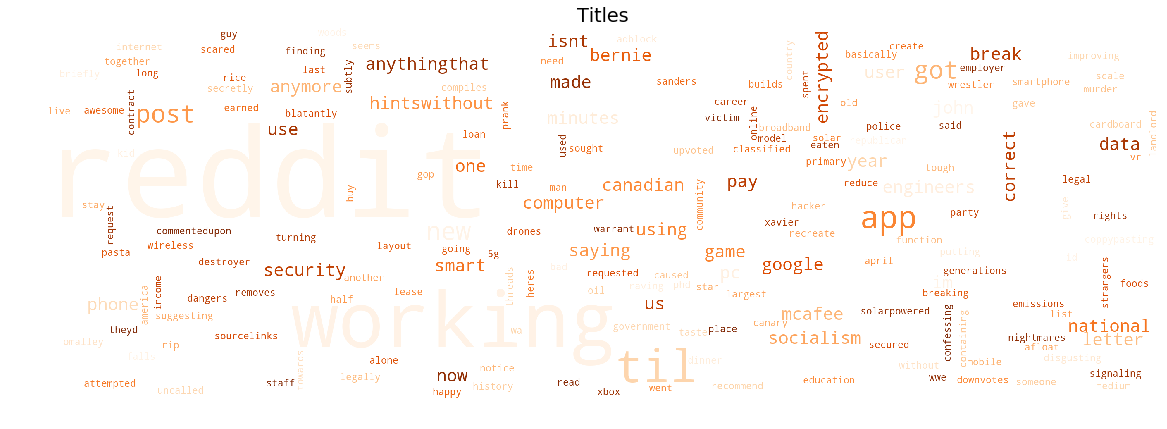

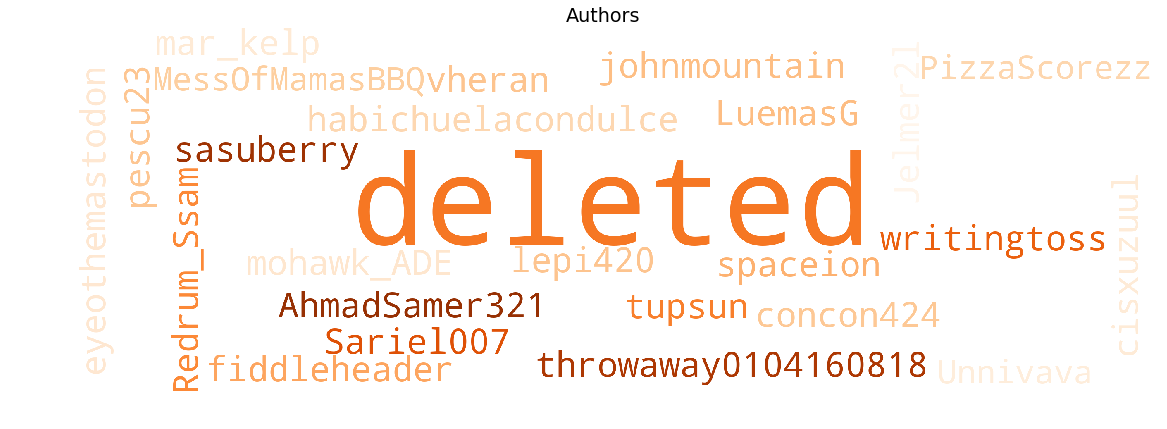

Cluster_ 2


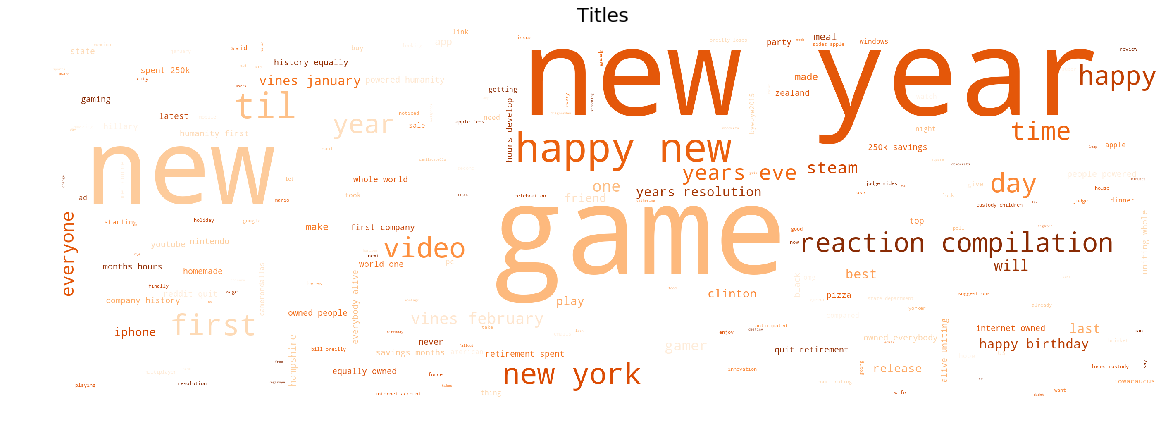

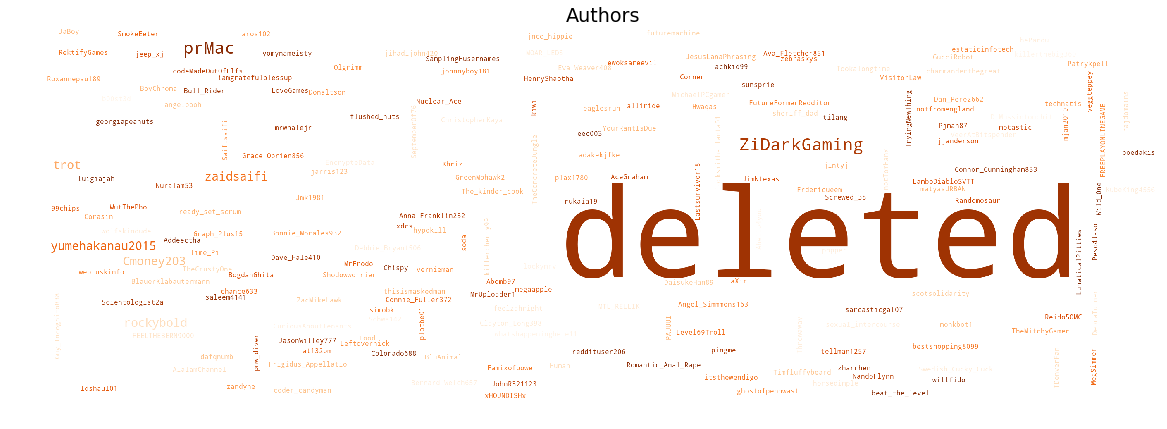

Cluster_ 3


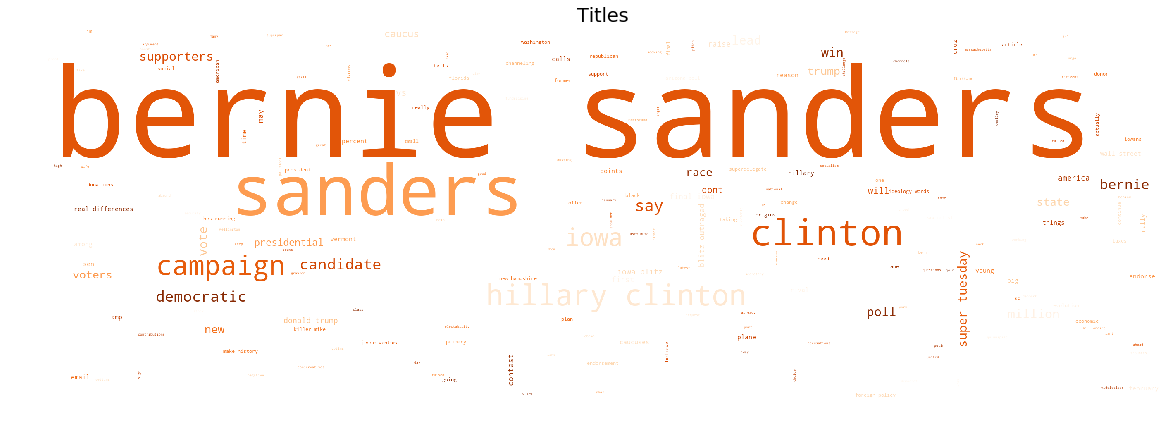

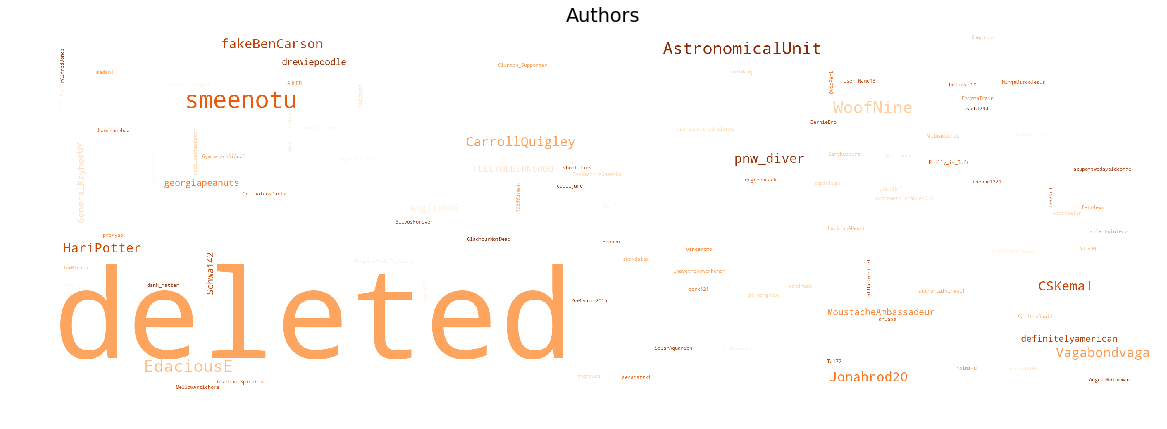

Cluster_ 4


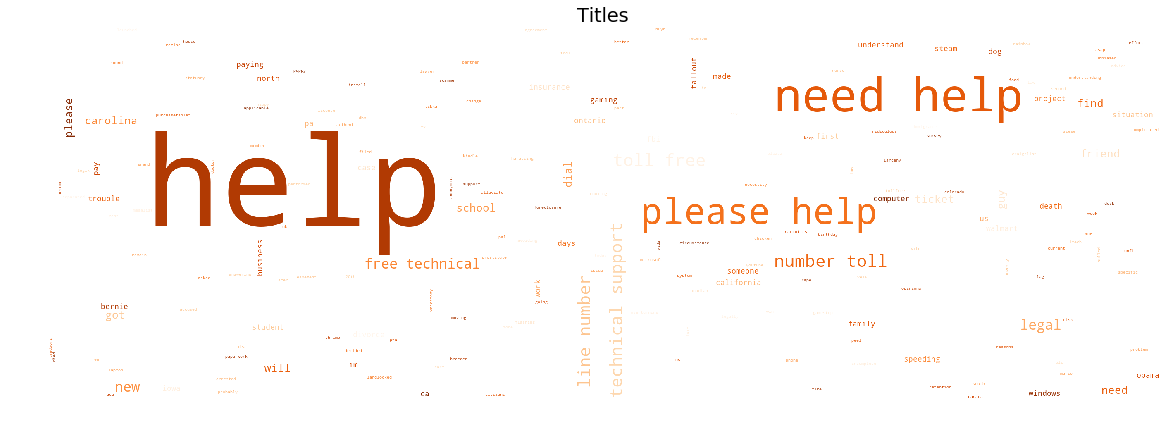

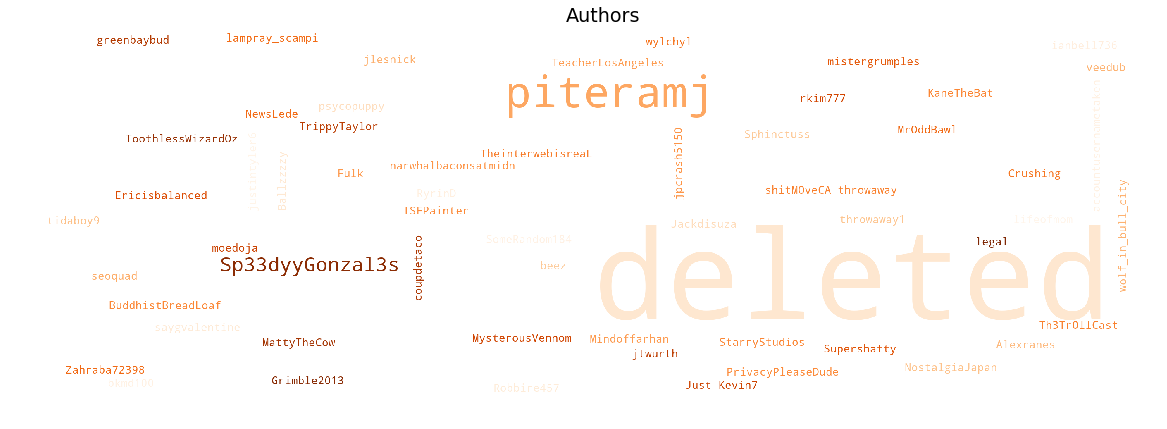

Cluster_ 5


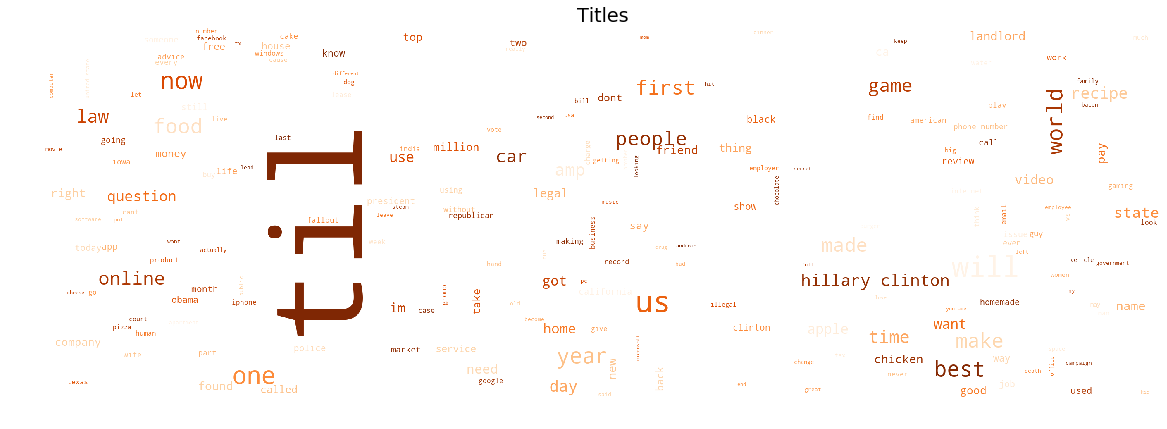

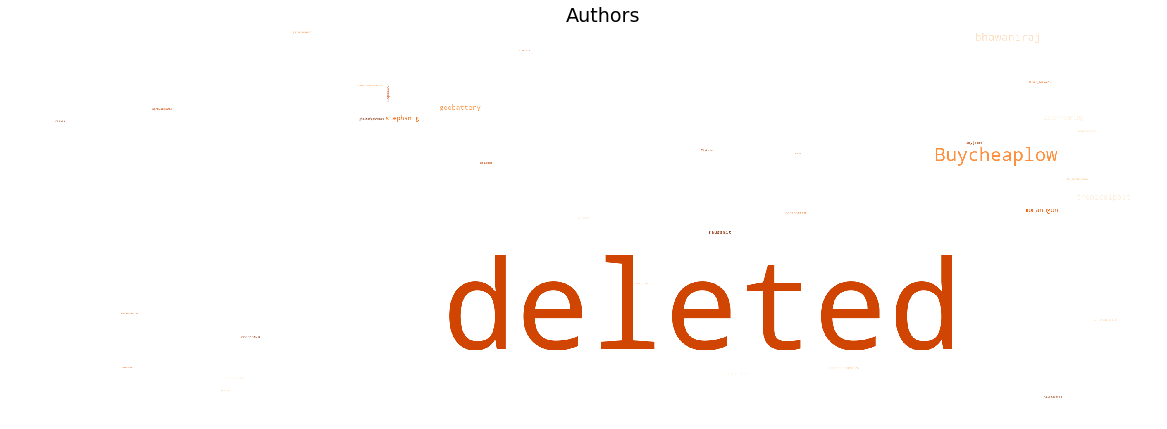

Cluster_ 6


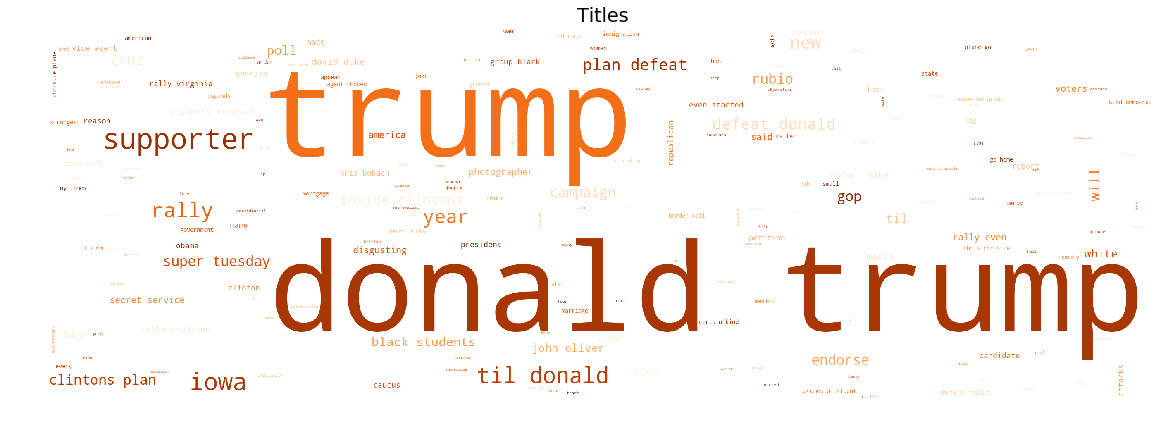

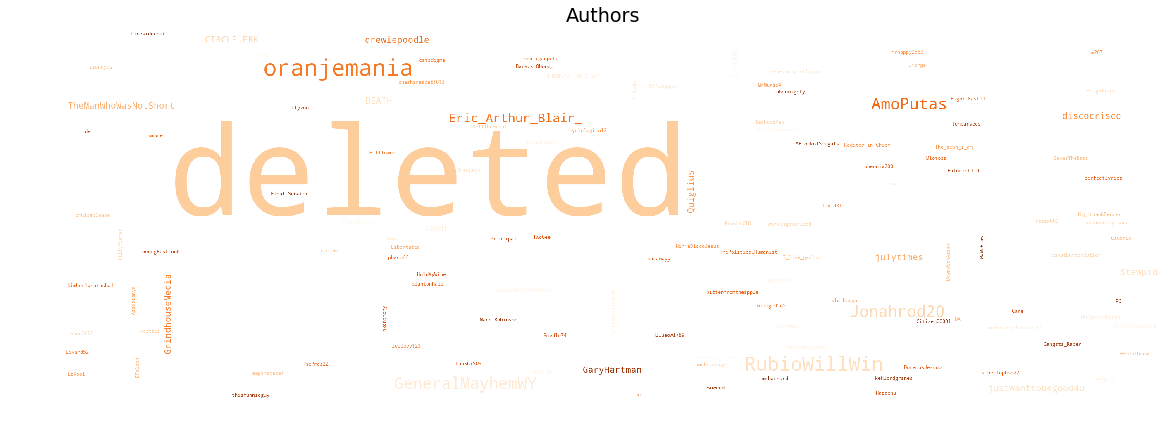

In [807]:
import wordcloud as wc
for i in range(0,6):
    print("Cluster_",i+1)
    c0_wc = wc.WordCloud(background_color='white', colormap='Oranges',width=2700,
                         height=900, relative_scaling=0.9,max_font_size=300,
                         min_font_size=5).generate(
        cluster_list[i]['clean'].str.cat(sep=' '))

    plt.figure(figsize=(20,8))
    plt.title('Titles')
    plt.imshow(c0_wc)
    plt.axis('off')
    plt.show()

    c0_wc = wc.WordCloud(background_color='white', colormap='Oranges',width=2700,
                         height=900, relative_scaling=0.9,max_font_size=300,
                         min_font_size=5).generate(
        cluster_list[i]['author'].str.cat(sep=' '))

    plt.figure(figsize=(20,8))
    plt.title('Authors')
    plt.imshow(c0_wc)
    plt.axis('off')
    plt.show()

By using the kmeans clustering after using TruncatedSVD with 6 clusters, we were able to reveal the six (6) different themes as the following:

1. reddit
2. new year
3. bernie sanders
4. help
5. til
6. donald trump

We failed to find any pattern where the '[deleted]' author was posting since it was present in all the clusters.

As we assess the quality of the clusters, we can see that the TruncatedSVD using 1000 components was able to eliminate a lot of words from the corpus. We now have six (6) clusters as compared to nine (9) before when we did not do any feature reduction. We now go back to evaluate whether the clusters answered the problem being solved. We can say that it did since the clusters revealed the themes. Although for clusters, like cluster 1, it was still a mix of different words. We now have six (6) clusters that can be possible subreddits.


# <font color='orangered'>7. Results

The notebook has presented two models of clustering of the thread titles from reddit. The first one was clustered with only special characters, foreign characters, and stopwords removed. This proved successful to cluster titles into more clusters as compared to the second model. The second model clustered the titles after reducing the number of features to 1000 using TruncatedSVD. Nine (9) clusters were formed in the first model and six (six) clusters were formed in the second model.

For the first model, by using the kmeans clustering on the bag of words from tfidf with 9 clusters, we were able to reveal the nine (9) different themes as the following:
1. Hillary Clinton, new, food, etc
2. Tech and games
3. Vines and games
4. Bernie Sanders
5. Need help
6. TIL (today I learned)
7. New Year
8. Car 
9. Donald Trump


For the second model, by using the kmeans clustering after using TruncatedSVD with 6 clusters, we were able to reveal the six (6) different themes as the following:

1. reddit
2. new year
3. bernie sanders
4. help
5. til
6. donald trump

For both models, we failed to find any pattern where the '[deleted]' author was posting since it was present in all the clusters.

It can be seen that each cluster formed represent a community of similar titles or themes that may correspond to a possible subreddit. The titles assigned to each cluster are representative of the features or words that define the cluster. The clusters are able to capture the titles being discussed under the common theme in each cluster.

Future directions of this algorithm can be extended as the engine of a forum moderator system. It can also be used for digital marketing targeting wherein similar words can be obtained based on the community being targeted.

# <font color='orangered'>8. Acknowledgement and Results

### Acknowledgement:
This is to acknowledge Prof Erika, Prof Ed, Prof Alis, MSDS2019, and MSDS2020.

### Data Source:
- Reddit
- Thomas K Landauer and Susan Dumais (2008), Scholarpedia, 3(11):4356. http://www.scholarpedia.org/article/Latent_semantic_analysis